# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import seaborn as sns
import math

from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
import joblib
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import joblib

## Chargement des données

In [2]:
# Chargement depuis parquet
df = pd.read_parquet("../data/clean/lille_2022.parquet")

# Filtrer biens avec exactement 4 pièces principales
df_4p = df[df['Nombre pieces principales'] == 4].copy()

#df_4p = df

In [3]:
colonnes_a_garder = [
    'Surface reelle bati',
    'Nombre pieces principales',
    'Nombre de lots',
    'Valeur fonciere',
    'Surface terrain',
    'Code type local',
    'prix_m2'
]

# logements
df_logements = df_4p[colonnes_a_garder].copy()

### Vérifier les types

In [4]:
df_logements.dtypes

Surface reelle bati          float64
Nombre pieces principales      Int64
Nombre de lots                 Int64
Valeur fonciere              float64
Surface terrain              float64
Code type local                Int64
prix_m2                      float64
dtype: object

In [5]:
# Remplacer Surface terrain NaN par 0 pour les appartements (Code type local == 2)
df_logements.loc[
    (df_logements["Code type local"] == 2) & (df_logements["Surface terrain"].isna()),
    "Surface terrain"
] = 0

# Remplacer Surface terrain NaN par 0 pour les maisons (Code type local == 1)
df_logements.loc[
    (df_logements["Code type local"] == 1) & (df_logements["Surface terrain"].isna()),
    "Surface terrain"
] = 0


#mettre surface terrain à 0 pour les appartements
#df_logements.loc[df_logements["Code type local"] == 2, "Surface terrain"] = 0

#mettre le nombre de lots pour les maison à 0
#df_logements.loc[df_logements["Code type local"] == 1, "Nombre de lots"] = 0

df_logements = df_logements.dropna()
df_logements = df_logements.drop_duplicates()

print(len(df_logements))

766


In [6]:
#séparation du dataset
df_maison = df_logements[df_logements["Code type local"] == 1]
df_appartement = df_logements[df_logements["Code type local"] == 2]

#df_maison = df_logements
#df_appartement = df_logements

In [7]:
def detect_outliers(df, column):
    
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    return lower_bound, upper_bound, outliers

In [8]:
# Pour df_logements
print("📦 Outliers prix_m2 (maisons) :")
print(detect_outliers(df_maison, "prix_m2")[2], "\n")

print("📦 Outliers prix_m2 (appartements) :")
print(detect_outliers(df_appartement, "prix_m2")[2], "\n")

📦 Outliers prix_m2 (maisons) :
      Surface reelle bati  Nombre pieces principales  Nombre de lots  \
1959                 64.0                          4               0   
2314                 60.0                          4               0   
2625                 82.0                          4               0   
5350                 52.0                          4               0   

      Valeur fonciere  Surface terrain  Code type local      prix_m2  
1959         515000.0             73.0                1  8046.875000  
2314         470000.0             91.0                1  7833.333333  
2625         753750.0             59.0                1  9192.073171  
5350         392900.0             58.0                1  7555.769231   

📦 Outliers prix_m2 (appartements) :
      Surface reelle bati  Nombre pieces principales  Nombre de lots  \
499                  95.0                          4               1   
534                  53.0                          4               0   

In [9]:
def remove_outliers(df, column):
    lower, upper, _ = detect_outliers(df, column)
    return df[(df[column] >= lower) & (df[column] <= upper)]

def median_outliers(df, column):
    lower, upper, _ = detect_outliers(df, column)
    mediane = df[column].median()
    df.loc[(df[column] < lower) | (df[column] > upper), column] = mediane
    return df

In [10]:
df_maison_clean = median_outliers(df_maison, "prix_m2")
df_appartement_clean = median_outliers(df_appartement, "prix_m2")

df_maison_clean = median_outliers(df_maison, "Nombre de lots")
df_appartement_clean = median_outliers(df_appartement, "Nombre de lots")

df_maison_clean = median_outliers(df_maison, "Surface terrain")
df_appartement_clean = median_outliers(df_appartement, "Surface terrain")

df_maison_clean = median_outliers(df_maison, "Surface reelle bati")
df_appartement_clean = median_outliers(df_appartement, "Surface reelle bati")


print(len(df_maison_clean))
print(len(df_appartement_clean))

352
414


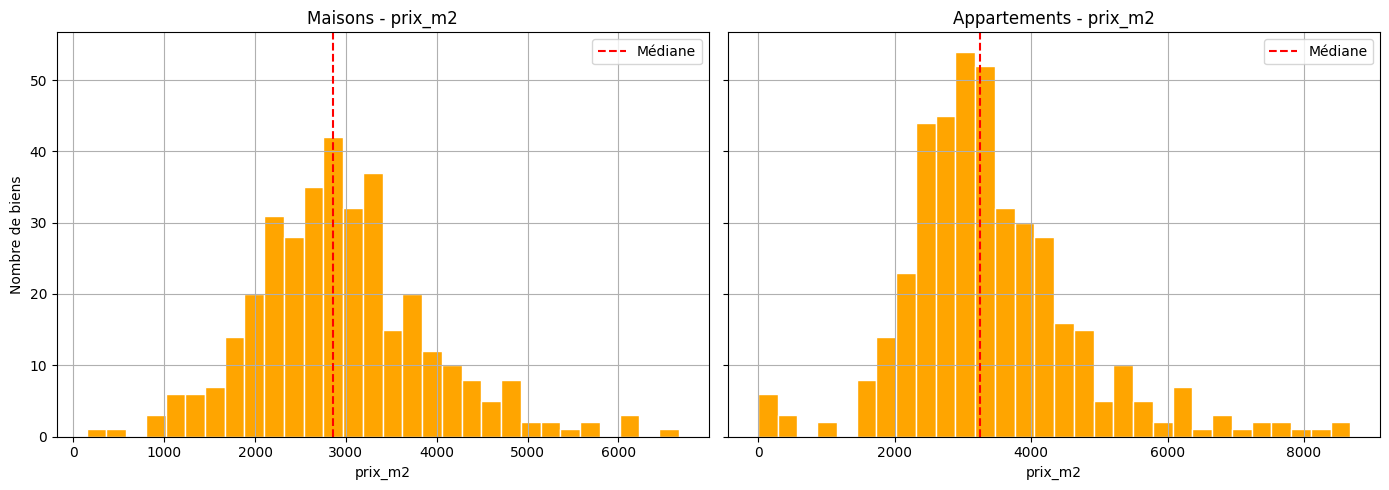

In [11]:
# Créer la figure et les 2 sous-graphiques côte à côte
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# --- 1. Histogramme pour les maisons ---
axs[0].hist(df_maison_clean['prix_m2'], bins=30, color='orange', edgecolor='w')
axs[0].axvline(np.median(df_maison_clean['prix_m2']), color='red', linestyle='--', label='Médiane')
axs[0].set_title("Maisons - prix_m2")
axs[0].set_xlabel("prix_m2")
axs[0].set_ylabel("Nombre de biens")
axs[0].grid(True)
axs[0].legend()

# --- 2. Histogramme pour les appartements ---
axs[1].hist(df_appartement_clean['prix_m2'], bins=30, color='orange', edgecolor='w')
axs[1].axvline(np.median(df_appartement_clean['prix_m2']), color='red', linestyle='--', label='Médiane')
axs[1].set_title("Appartements - prix_m2")
axs[1].set_xlabel("prix_m2")
axs[1].grid(True)
axs[1].legend()

# Ajuster l'espacement
plt.tight_layout()
plt.show()

In [12]:
# Pour les maisons
df_maisons = df_maison_clean[(df_maison_clean["prix_m2"] >= 1500) & (df_maison_clean["prix_m2"] <= 5000)]

# # Pour les appartements
df_appartements = df_appartement_clean[(df_appartement_clean["prix_m2"] >= 2000) & (df_appartement_clean["prix_m2"] <= 7000)]

df_maisons = df_maison_clean
df_appartements = df_appartement_clean

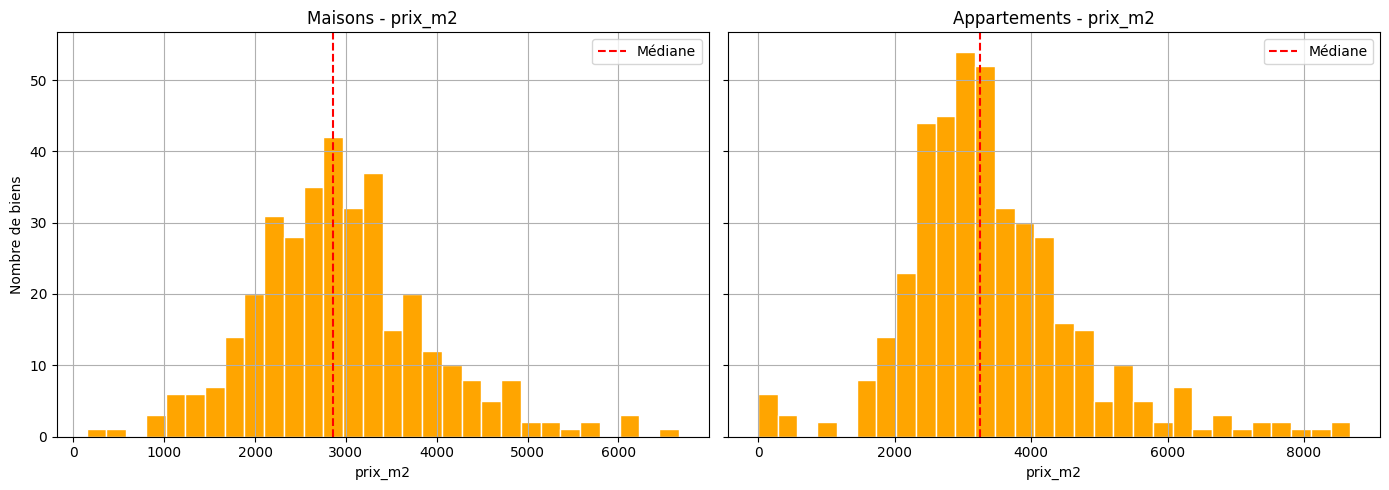

In [13]:
# Créer la figure et les 2 sous-graphiques côte à côte
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# --- 1. Histogramme pour les maisons ---
axs[0].hist(df_maisons['prix_m2'], bins=30, color='orange', edgecolor='w')
axs[0].axvline(np.median(df_maisons['prix_m2']), color='red', linestyle='--', label='Médiane')
axs[0].set_title("Maisons - prix_m2")
axs[0].set_xlabel("prix_m2")
axs[0].set_ylabel("Nombre de biens")
axs[0].grid(True)
axs[0].legend()

# --- 2. Histogramme pour les appartements ---
axs[1].hist(df_appartements['prix_m2'], bins=30, color='orange', edgecolor='w')
axs[1].axvline(np.median(df_appartements['prix_m2']), color='red', linestyle='--', label='Médiane')
axs[1].set_title("Appartements - prix_m2")
axs[1].set_xlabel("prix_m2")
axs[1].grid(True)
axs[1].legend()

# Ajuster l'espacement
plt.tight_layout()
plt.show()

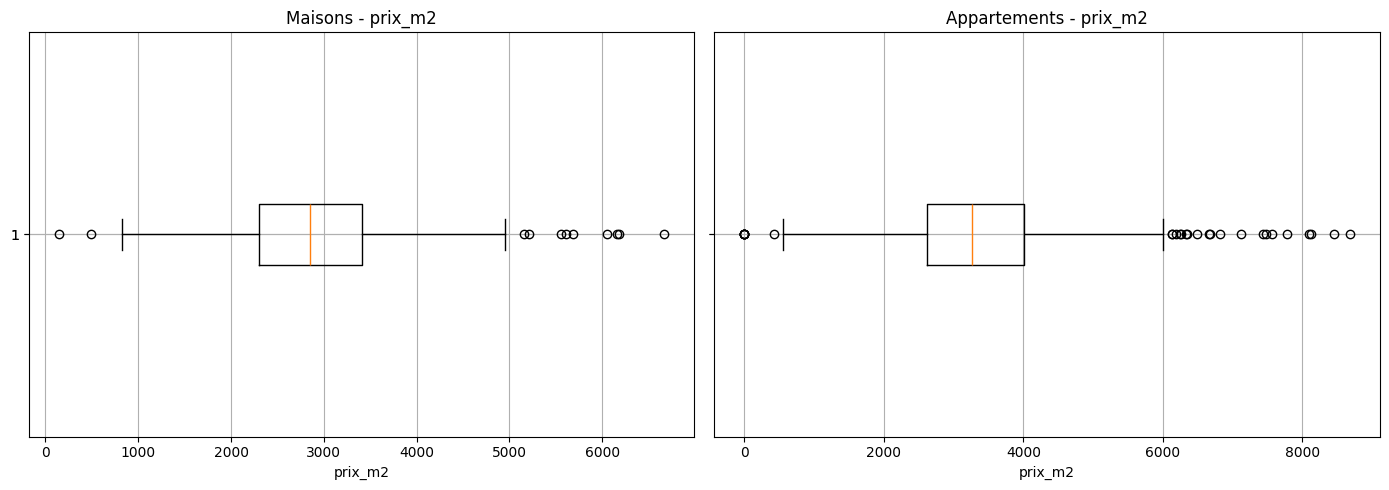

In [14]:
import matplotlib.pyplot as plt

# Créer la figure et les 2 sous-graphiques côte à côte
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# --- 1. Boxplot pour les maisons ---
axs[0].boxplot(df_maisons['prix_m2'], vert=False)
axs[0].set_title("Maisons - prix_m2")
axs[0].set_xlabel("prix_m2")
axs[0].grid(True)

# --- 2. Boxplot pour les appartements ---
axs[1].boxplot(df_appartements['prix_m2'], vert=False)
axs[1].set_title("Appartements - prix_m2")
axs[1].set_xlabel("prix_m2")
axs[1].grid(True)

# Ajuster l'espacement
plt.tight_layout()
plt.show()


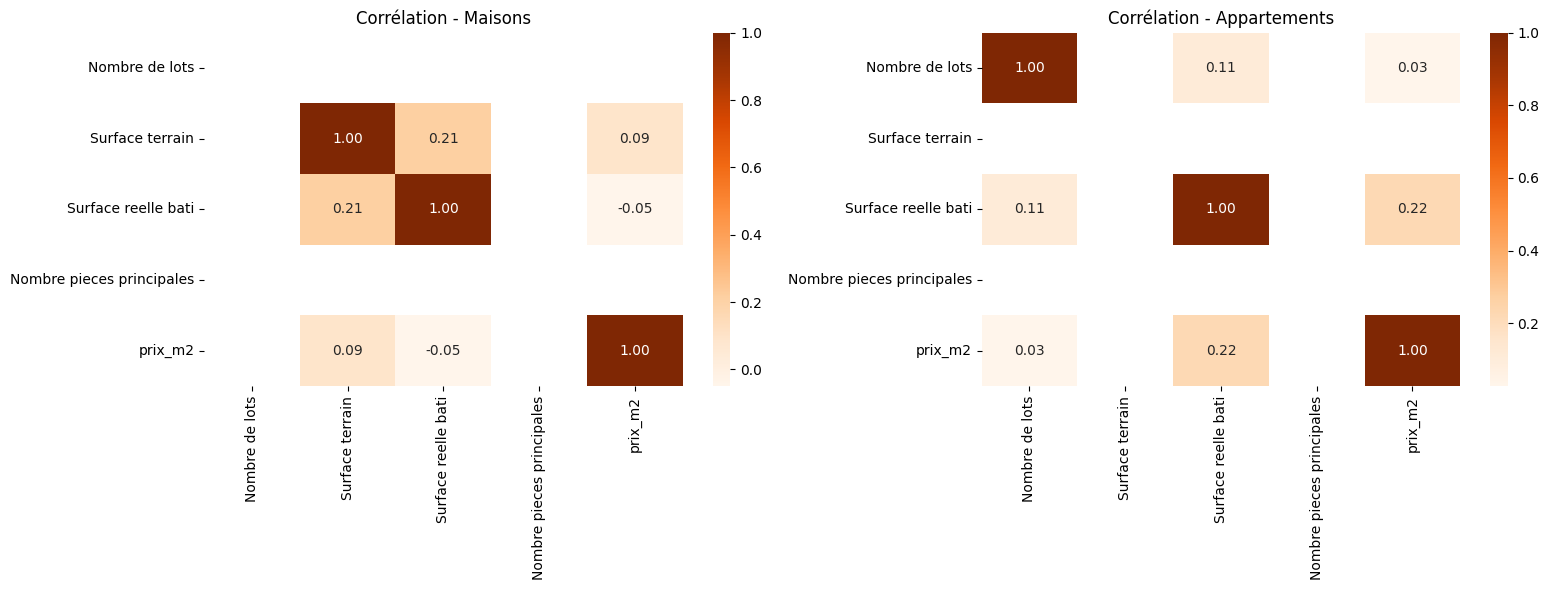

In [15]:
# matrices de corrélation
corr_maison = df_maisons[["Nombre de lots",
                        "Surface terrain", "Surface reelle bati", "Nombre pieces principales", "prix_m2"]].corr()
corr_appartement = df_appartements[["Nombre de lots",
                        "Surface terrain", "Surface reelle bati", "Nombre pieces principales", "prix_m2"]].corr()

# Création des sous-figures
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap pour les maisons
sns.heatmap(corr_maison, ax=axs[0], cmap='Oranges', annot=True, fmt=".2f")
axs[0].set_title("Corrélation - Maisons")

# Heatmap pour les appartements
sns.heatmap(corr_appartement, ax=axs[1], cmap='Oranges', annot=True, fmt=".2f")
axs[1].set_title("Corrélation - Appartements")

plt.tight_layout()
plt.show()

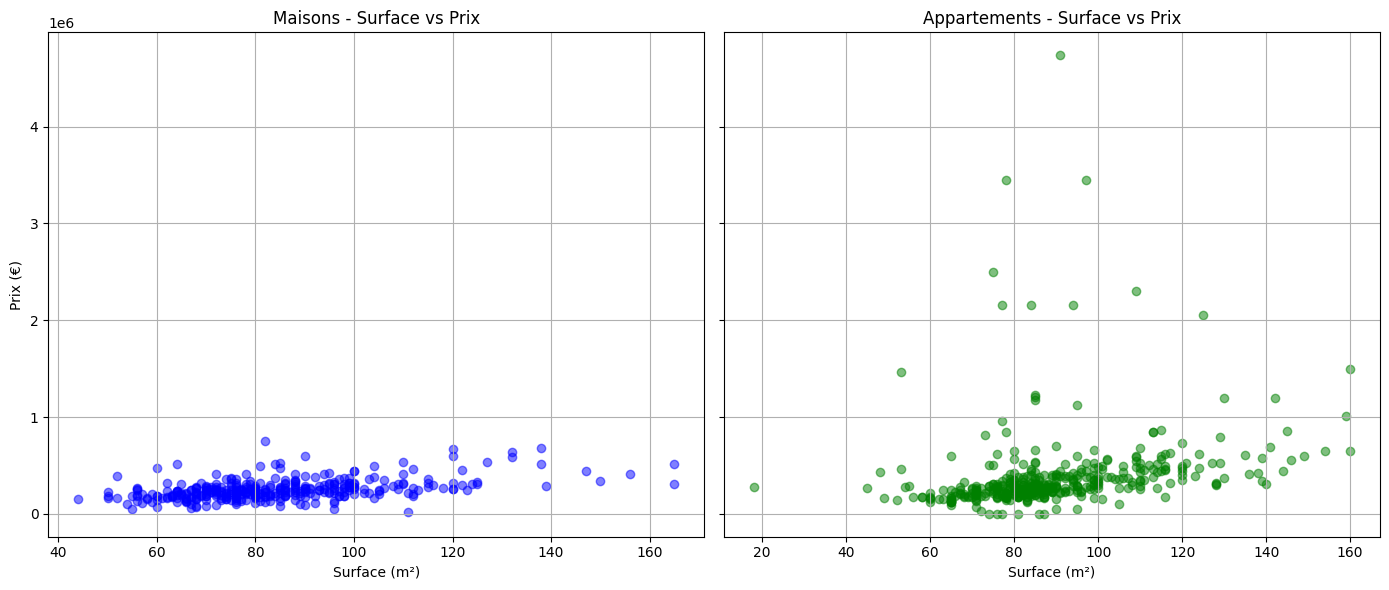

In [16]:
# Créer la figure avec 2 sous-graphes
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Scatter plot pour les maisons ---
axs[0].scatter(df_maisons['Surface reelle bati'], df_maisons['Valeur fonciere'], color='blue', alpha=0.5)
axs[0].set_title("Maisons - Surface vs Prix")
axs[0].set_xlabel("Surface (m²)")
axs[0].set_ylabel("Prix (€)")
axs[0].grid(True)

# --- Scatter plot pour les appartements ---
axs[1].scatter(df_appartements['Surface reelle bati'], df_appartements['Valeur fonciere'], color='green', alpha=0.5)
axs[1].set_title("Appartements - Surface vs Prix")
axs[1].set_xlabel("Surface (m²)")
axs[1].grid(True)

# Ajuster l'affichage
plt.tight_layout()
plt.show()

In [17]:

# results_maisons = []
# results_appartements = []

# # Variables explicatives
# features_maisons = ["Nombre de lots", "Surface terrain", "Surface reelle bati"]

# features_appartements = ["Nombre de lots", "Surface terrain", "Surface reelle bati"]

# X_maison = df_maison[features_maisons]
# X_appartement = df_appartement[features_appartements]

# # Variable cible
# y_maison = df_maison["prix_m2"]
# y_appartement = df_appartement["prix_m2"]


# # Division en jeu d'entraînement (80%) et test (20%)
# X_train_maison, X_test_maison, y_train_maison, y_test_maison = train_test_split(X_maison, y_maison, test_size=0.2, random_state=42)
# X_train_appartement, X_test_appartement, y_train_appartement, y_test_appartement = train_test_split(X_appartement, y_appartement, test_size=0.2, random_state=42)


# # Optimisation DecisionTreeRegressor
# param_dt = {
#     "max_depth": [3, 5, 10, None],
#     "min_samples_split": [2, 5, 10]
# }

# param_rf = {
#     "n_estimators": [50, 100],
#     "max_depth": [5, 10, None],
#     "min_samples_split": [2, 5]
# }

# models = {
#     "Linear Regression": LinearRegression(),
#     "Decision Tree": DecisionTreeRegressor(random_state=42),
#     "Random Forest": RandomForestRegressor(random_state=42),
#     "GridSearchCV DT": GridSearchCV(DecisionTreeRegressor(random_state=42), param_dt, cv=5, scoring='neg_mean_squared_error'),
#     "GridSearchCV RF": GridSearchCV(RandomForestRegressor(random_state=42), param_rf, cv=5, scoring='neg_mean_squared_error'),  # Ajout du RF optimisé
#     "XGBoost": XGBRegressor(random_state=42)
# }

# # fonction pour pipeline

# def pipeline_result(models, X_train, y_train, X_test, y_test):
#     results = []
#     for name, model in models.items():
        
#         pipeline = Pipeline([
#             ('scaler', StandardScaler()),
#             ('model', model)
#         ])

#         pipeline.fit(X_train, y_train)
#         y_pred = pipeline.predict(X_test)
#         mse = mean_squared_error(y_test, y_pred)
#         rmse = np.sqrt(mse)
#         mae = mean_absolute_error(y_test, y_pred)
#         r2 = r2_score(y_test, y_pred)              
#         results.append({"Modele": name, "MSE": mse, "RMSE": rmse, "MAE": mae, "R2 Score": r2})
#     return results , pipeline

# # pipeline maison + appartement
# pipeline_result_maison = pipeline_result(models, X_train_maison, y_train_maison, X_test_maison, y_test_maison)
# pipeline_result_appartement = pipeline_result(models, X_train_appartement, y_train_appartement, X_test_appartement, y_test_appartement)

# results_maisons = pipeline_result_maison[0]
# results_appartements = pipeline_result_appartement[0]

# # 🔹 Créer les DataFrames pour chaque type de bien
# df_resultats_maisons = pd.DataFrame(results_maisons)
# df_resultats_appartements = pd.DataFrame(results_appartements)

# # 🔹 Trier par MSE croissant (meilleur modèle en haut)
# df_resultats_maisons = df_resultats_maisons.sort_values(by="MSE", ascending=True)
# df_resultats_appartements = df_resultats_appartements.sort_values(by="MSE", ascending=True)

# # 🔹 Afficher les tableaux
# print("🏠 Tableau comparatif - MAISONS :")
# display(df_resultats_maisons[["Modele", "MSE", "RMSE", "MAE", "R2 Score"]])

# print("\n🏢 Tableau comparatif - APPARTEMENTS :")
# display(df_resultats_appartements[["Modele", "MSE", "RMSE", "MAE", "R2 Score"]])
    
# def plot_predictions(models, type,X_train, y_train, X_test, y_test, titre):
#     n_models = len(models)
#     n_cols = 2  # fixe à 2 colonnes
#     n_rows = math.ceil(n_models / n_cols)  # calcule le nombre de lignes

#     plt.figure(figsize=(7 * n_cols, 5 * n_rows))

#     for i, (name, model) in enumerate(models.items()):
#         pipeline = Pipeline([
#             ('scaler', StandardScaler()),
#             ('model', model)
#         ])
#         pipeline.fit(X_train, y_train)
#         y_pred = pipeline.predict(X_test)

#         plt.subplot(n_rows, n_cols, i + 1)
#         plt.scatter(y_test, y_pred, alpha=0.6, edgecolor='k')
#         plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
#         plt.xlabel("Valeurs réelles (prix/m²)")
#         plt.ylabel("Valeurs prédites (prix/m²)")
#         plt.title(name)
#         plt.grid(True)
        

#     plt.suptitle(titre, fontsize=16)
#     plt.tight_layout(rect=[0, 0, 1, 0.95])
#     plt.show()

# # 📈 Graphe pour les maisons
# plot_predictions(models, "maison",X_train_maison, y_train_maison, X_test_maison, y_test_maison, "🏠 Prédictions pour les maisons")

# # 📈 Graphe pour les appartements
# plot_predictions(models, "appartement",X_train_appartement, y_train_appartement, X_test_appartement, y_test_appartement, "🏢 Prédictions pour les appartements")

## Ajout des feature

In [18]:
# --- Supposons que df_maison et df_appartement sont déjà prêts ---

features_maison = ["Surface terrain", "Surface reelle bati"]
features_appartement = ["Nombre de lots", "Surface reelle bati"]

# Données maisons
X_maison = df_maisons[features_maison]
y_maison = df_maisons["prix_m2"]

# Données appartements
X_appartement = df_appartements[features_appartement]
y_appartement = df_appartements["prix_m2"]

# Split train/test
X_train_maison, X_test_maison, y_train_maison, y_test_maison = train_test_split(
    X_maison, y_maison, test_size=0.2, random_state=42
)
X_train_appartement, X_test_appartement, y_train_appartement, y_test_appartement = train_test_split(
    X_appartement, y_appartement, test_size=0.2, random_state=42
)

## Optimisation des modèles

In [19]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Paramètres pour GridSearch
param_dt = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10]
}

param_rf = {
    "n_estimators": [50, 100],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5]
}

param_xgb = {
    "n_estimators": [50, 100],
    "max_depth": [3, 5, 10],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1],
}

def optimize_models(X_train, y_train):
    # DecisionTree
    grid_dt = GridSearchCV(
        DecisionTreeRegressor(random_state=42),
        param_dt,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
    )
    grid_dt.fit(X_train, y_train)
    best_dt = grid_dt.best_estimator_
    print(f"Best Decision Tree params: {grid_dt.best_params_}")

    # RandomForest
    grid_rf = GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_rf,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
    )
    grid_rf.fit(X_train, y_train)
    best_rf = grid_rf.best_estimator_
    print(f"Best Random Forest params: {grid_rf.best_params_}")
    
    # XGBoost
    grid_xgb = GridSearchCV(
        XGBRegressor(random_state=42),
        param_xgb,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        verbose=0
    )
    grid_xgb.fit(X_train, y_train)
    best_xgb = grid_xgb.best_estimator_
    print(f"Best XGBoost params: {grid_xgb.best_params_}")

    return best_dt, best_rf, best_xgb

# Exemple d’appel
best_dt_maison, best_rf_maison, best_xgb_maison = optimize_models(X_train_maison, y_train_maison)
best_dt_appartement, best_rf_appartement, best_xgb_appartement = optimize_models(X_train_appartement, y_train_appartement)


Best Decision Tree params: {'max_depth': 3, 'min_samples_split': 5}
Best Random Forest params: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
Best XGBoost params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Best Decision Tree params: {'max_depth': 3, 'min_samples_split': 5}
Best Random Forest params: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
Best XGBoost params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


## Création + entrainement des pipeline

In [20]:
# VotingRegressor enrichi
voting_maison = VotingRegressor(
    estimators=[
        ("lr", LinearRegression()),
        ("dt", best_dt_maison),
        ("rf", best_rf_maison),
        ("xgb", best_xgb_maison)
    ]
)

voting_appartement = VotingRegressor(
    estimators=[
        ("lr", LinearRegression()),
        ("dt", best_dt_appartement),
        ("rf", best_rf_appartement),
        ("xgb", best_xgb_appartement)
    ]
)

# Pipelines
pipeline_maison = Pipeline([
    ("scaler", StandardScaler()),
    ("voting", voting_maison),
])

pipeline_appartement = Pipeline([
    ("scaler", StandardScaler()),
    ("voting", voting_appartement),
])

pipeline_maison.fit(X_train_maison, y_train_maison)
pipeline_appartement.fit(X_train_appartement, y_train_appartement)

,steps,"[('scaler', ...), ('voting', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,estimators,"[('lr', ...), ('dt', ...), ...]"
,weights,None
,n_jobs,None
,verbose,False


## Evaluation des pipelines

In [21]:

# Évaluation
def eval_pipeline(pipeline, X_test, y_test, type_bien):
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R2: {r2}") 

print("Valeur maison:")
y_pred_maison = eval_pipeline(pipeline_maison, X_test_maison, y_test_maison, "MAISON")
print("Valeur appartement:")
y_pred_appartement = eval_pipeline(pipeline_appartement, X_test_appartement, y_test_appartement, "APPARTEMENT")

Valeur maison:
MSE: 1183684.6875441272, RMSE: 1087.9727420961094, MAE: 765.6749243940394, R2: -0.01113745683673284
Valeur appartement:
MSE: 1758515.4097176127, RMSE: 1326.090272084677, MAE: 948.7029546828259, R2: 0.05146299029528223


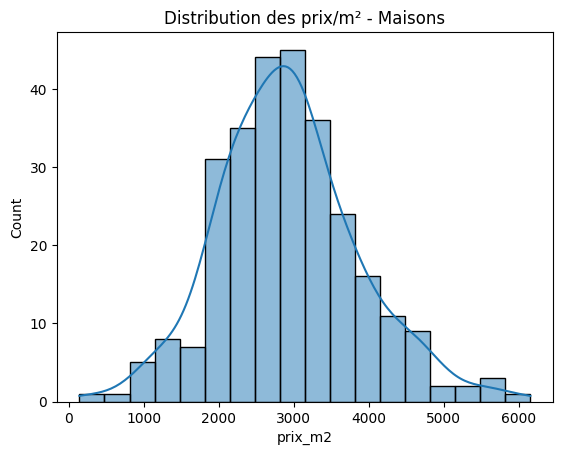

Maisons : 281
Appartements : 331
prix_m2_predit         1.000000
Surface terrain       -0.060008
Surface reelle bati   -0.557520
Name: prix_m2_predit, dtype: float64


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(y_train_maison, kde=True)
plt.title("Distribution des prix/m² - Maisons")
plt.show()

print("Maisons :", len(X_train_maison))
print("Appartements :", len(X_train_appartement))

import pandas as pd

df_maison = X_train_maison.copy()
df_maison["prix_m2_predit"] = y_train_maison / df_maison["Surface reelle bati"]

corr = df_maison.corr(numeric_only=True)
print(corr["prix_m2_predit"].sort_values(ascending=False))


In [23]:
# import pandas as pd
# import numpy as np
# import math
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestRegressor, VotingRegressor
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.linear_model import LinearRegression
# from xgboost import XGBRegressor
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# import matplotlib.pyplot as plt
# import joblib





# # Graphiques
def plot_predictions(y_test, y_pred, titre):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, edgecolor="k")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
    plt.xlabel("Valeurs réelles (prix/m²)")
    plt.ylabel("Valeurs prédites (prix/m²)")
    plt.title(titre)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def compare_models(X_train, X_test, y_train, y_test, bien_label, best_dt, best_rf, best_xgb, pipeline_votingRegressor):
    models = {
        "LinearRegression": LinearRegression(),
        "DecisionTree": best_dt,
        "RandomForest": best_rf,
        "XGBoost": best_xgb,
        "VotingRegressor": pipeline_votingRegressor
    }

    pipeline_export = {}
    results = []
    for name, model in models.items():
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", model)
        ])
        pipe.fit(X_train, y_train)
        pipeline_export[name] = pipe
        y_pred = pipe.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results.append({
            "Modele": name,
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2
        })

    df_result = pd.DataFrame(results).sort_values(by="MSE")
    print(f"\n📋 Résultats comparatifs - {bien_label}")
    print(df_result.to_string(index=False))
    return results, pipeline_export, df_result

# # Comparaison pour maisons et appartements
results_maisons, pipeline_modele_maison, dt_classement_maison = compare_models(
    X_train_maison, X_test_maison, y_train_maison, y_test_maison,
    "MAISON", best_dt_maison, best_rf_maison, best_xgb_maison, pipeline_maison
)

results_appartements, pipeline_modele_appartement, dt_classement_appartement = compare_models(
    X_train_appartement, X_test_appartement, y_train_appartement, y_test_appartement,
    "APPARTEMENT", best_dt_appartement, best_rf_appartement, best_xgb_appartement, pipeline_appartement
)


📋 Résultats comparatifs - MAISON
          Modele          MSE        RMSE        MAE        R2
 VotingRegressor 1.183685e+06 1087.972742 765.674924 -0.011137
         XGBoost 1.187944e+06 1089.928485 774.060059 -0.014776
LinearRegression 1.193068e+06 1092.276439 771.031073 -0.019153
    DecisionTree 1.240085e+06 1113.590889 801.176100 -0.059316
    RandomForest 1.259839e+06 1122.425552 781.293923 -0.076191

📋 Résultats comparatifs - APPARTEMENT
          Modele          MSE        RMSE         MAE        R2
         XGBoost 1.678713e+06 1295.651505  920.604461  0.094508
 VotingRegressor 1.758515e+06 1326.090272  948.702955  0.051463
    RandomForest 1.779205e+06 1333.868587  965.313709  0.040303
    DecisionTree 1.816788e+06 1347.882852 1003.970637  0.020031
LinearRegression 2.001143e+06 1414.617598  996.002414 -0.079409


In [ ]:
import json

result = {
    "maison": results_maisons,
    "appartement": results_appartements
}

# #Sauvegarde des données dans un fichier JSON
with open("resultats_modeles_maison_appartement.json", "w", encoding="utf-8") as f:
    json.dump(result, f, ensure_ascii=False, indent=2)

# 💾 Sauvegarde des pipelines
joblib.dump(pipeline_modele_maison, "../models/pipeline_maison_models.pkl")
joblib.dump(pipeline_modele_appartement, "../models/pipeline_appartement_models.pkl")

dt_classement_maison

meilleur_modele_maison = dt_classement_maison.iloc[0]["Modele"]
meilleur_modele_appartement = dt_classement_appartement.iloc[0]["Modele"]

# 💾 Sauvegarde des modeles pour Lille
os.makedirs("../app/models/Lille", exist_ok=True)
joblib.dump(pipeline_modele_maison[meilleur_modele_maison], "../app/models/Lille/models_maison_Lille.pkl")
joblib.dump(pipeline_modele_appartement[meilleur_modele_appartement], "../app/models/Lille/models_appartement_Lille.pkl")

FileNotFoundError: [Errno 2] No such file or directory: '../app/models/Lille/models_maison_Lille.pkl'